# Find results by country in DigitalNZ

Many items in DigtalNZ include location information. This can include a country, but as far as I can see there's no direct way to search for results relating to a particular country using the API.

You can, however, search for geocoded locations using bounding boxes. This notebook shows how you can use this to search for countries. It makes use of the handy [country-bounding-boxes](https://github.com/graydon/country-bounding-boxes) Python package.

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!.</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them. When you hover over them a <i class="fa-step-forward fa"></i> icon appears.</li>
        <li>To run a code cell either click the <i class="fa-step-forward fa"></i> icon, or click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>
</div>

In [138]:
import requests
import pandas as pd
from country_bounding_boxes import country_subunits_by_iso_code
import ipywidgets as widgets
import iso3166
from tqdm import tqdm_notebook
from vega_datasets import data as vega_data
import altair as alt
from IPython.display import display, HTML
import random

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Get your DigitalNZ API key

[Get yourself an API key](https://digitalnz.org/developers/getting-started) and paste it between the quotes below.

In [151]:
api_key = ''
print('Your API key is: {}'.format(api_key))

Your API key is: 


## Make a results by country widget

First we'll make a little widget that you can use to find the number of results in DigitalNZ for a particular country.

In [148]:
def search_by_country(country):
    # Set basic parameters for the API query
    params = {
        'api_key': api_key,
        'text': ''
    }
    result_count = 0
    
    # We'll collect the results we get to display a sample
    results = []
    
    # Get bounding boxes for the supplied two letter country code
    # Note that there may be more than one bounding box per country
    bboxes = [c.bbox for c in country_subunits_by_iso_code(country.alpha2)] 
    
    # Loop through bounding boxes
    for bbox in bboxes:
        
        # DigitalNZ expects a bounding box in the format N,W,S,E.
        # We have to reorganise things and save the bbox as a string to use in the API query
        bbox_str = '{3},{0},{1},{2}'.format(*bbox)
        
        # Add the bbox to the query params
        params['geo_bbox'] = bbox_str
        
        # Make the request
        response = requests.get('http://api.digitalnz.org/v3/records.json', params)
        
        # Get the result as JSON
        data = response.json()
        
        # Get the total results
        result_count += data['search']['result_count']
        
        # Add the results to our collection for this country
        results += data['search']['results']
        
        # Display the number of results
        html = '<h4>There are {:,} items related to {}.</h4>'.format(result_count, country.name)
        if results:
            # If there are more than 10 results select a random sample of 10
            sample = 10 if len(results) > 10 else len(results)
            html += '<p>Here are {} of {:,} results:</p><ul>'.format(sample, result_count)
        
            # Display a random sample of results
            for result in random.sample(results, sample):
                html += '<li><a target="blank" href="{}">{}</li>'.format(result['source_url'], result['title'])
            html += '</ul>'
    display(HTML(html))

In [149]:
# This widget is bound to the search_by_country function
# Selecting a country will run the function and display the results
widgets.interact(search_by_country, country=iso3166.countries_by_name);

interactive(children=(Dropdown(description='country', options={'AFGHANISTAN': Country(name='Afghanistan', alph…

## Find the number of results for every country

Now we'll get the number of results for every country and do something with them.

In [79]:
def totals_by_country():
    country_totals = []
    params = {
        'api_key': api_key,
        'text': ''
    }
    for country in tqdm_notebook(iso3166.countries):
        result_count = 0
        bboxes = [c.bbox for c in country_subunits_by_iso_code(country.alpha2)] 
        for bbox in bboxes:
            # DigitalNZ expects N,W,S,E
            bbox_str = '{3},{0},{1},{2}'.format(*bbox)
            params['geo_bbox'] = bbox_str
            response = requests.get('http://api.digitalnz.org/v3/records.json', params)
            data = response.json()
            result_count += data['search']['result_count']
        country_totals.append({'country': country.name, 'alpha_code': country.alpha2, 'numeric_code': int(country.numeric), 'results': result_count})
    return country_totals            

In [80]:
totals = totals_by_country()

In [122]:
# Convert the results to a dataframe
df = pd.DataFrame(totals).sort_values(['results'], ascending=False)
df.head(10)

,alpha_code,country,numeric_code,results
159,NZ,New Zealand,554,488854
8,AQ,Antarctica,10,18366
75,FR,France,250,436
13,AU,Australia,36,422
164,NF,Norfolk Island,574,270
21,BE,Belgium,56,261
158,NC,New Caledonia,540,242
236,US,United States of America,840,200
235,GB,United Kingdom of Great Britain and Northern I...,826,200
85,GR,Greece,300,190


In [82]:
# Save the results to a CSV file in case you want to download
df.to_csv('country_totals.csv', index=False)
display(HTML('<a target="_blank" href="country_totals.csv">Download file</a>'))

## Dispay the results on a choropleth map

As you can see from the sample above, New Zealand and Antarctica have *lots* more item than anywhere else. To make it possible to see differences between the other countries in the world, we'll limit the scale of the map to 600.

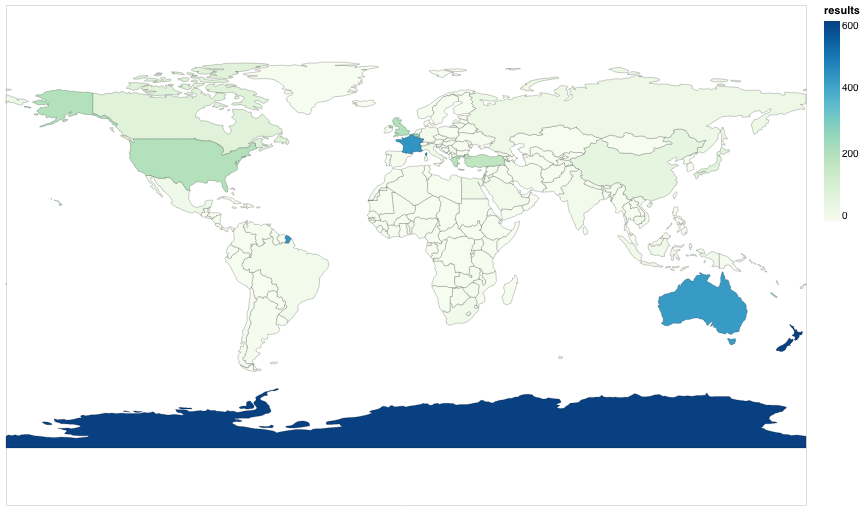

In [121]:
# Get the country outlines
world = alt.topo_feature(vega_data.world_110m.url, 'countries')

# Create the chart
# Note domain setting to limit upper value of scale
alt.Chart(world).mark_geoshape(stroke='black', strokeWidth=0.2).encode(
    color=alt.Color('results:Q', scale=alt.Scale(scheme='greenblue', domain=[0,600]))
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(df, 'numeric_code', ['results'])
).project(
    type='equirectangular'
).properties(
    width=800,
    height=500
)